<a href="https://colab.research.google.com/github/samuelj1323/ML_Learning/blob/main/Multi_class_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

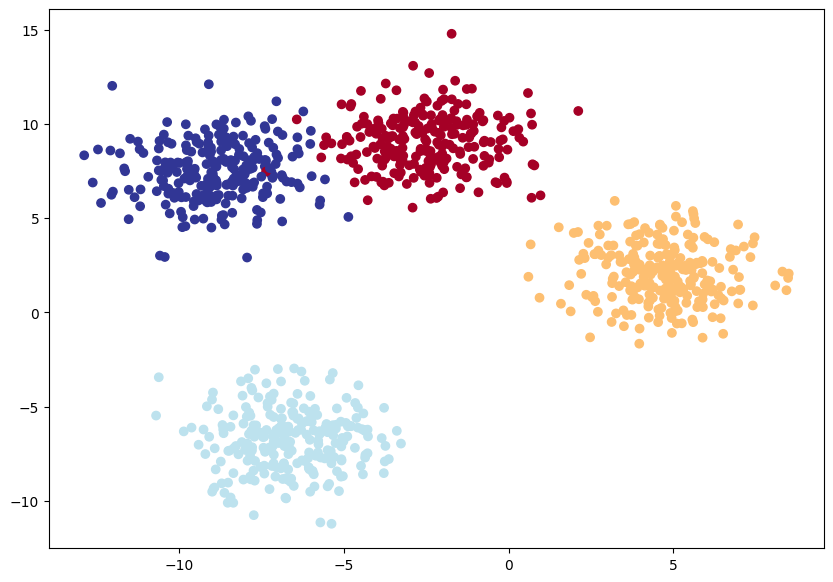

In [1]:
#Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create mulit-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            ) #Give them a. little shakeup
#Turn Data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split train_test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)


#Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)






### Building a multi-clas classification model in pytorch

In [2]:
#Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
#Build muit=class classification
from torch import nn
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classiciation model.
    Args:
      input_features (int): Number of input features to the model
      output_featrues (int): Number of outputs features (number of output classes)
      hidden_unit (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)



In [4]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [5]:
#Create an instance of blobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8
                    ).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create. a loss function and an optimizer for a multi-class problem

In [6]:
#Create a loss function for multi-class classification - how wrong model is
loss_fn = nn.CrossEntropyLoss()
#Create an optimizer for multi-class classification - updates params, to reduce loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.05)


#Getting prediction probabilities for a multi-class pyorch model

In order to evaluate and train and test our model, we need to convert out model's outputs (logits) to prediction probabilities and then to prediction labels

Logits (raw output of model) -> pred probs (use torch.softmax) -> Pred labels (take the argmax of the prediction probabilities)


In [7]:
#Lets get some raw ouputs of our model: Logits
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_test.to(device))
y_logits = y_preds
y_logits[:10]

tensor([[ 0.1778, -0.0869, -1.1588,  1.2413],
        [ 0.0380,  1.1486, -2.6173,  0.3912],
        [ 0.0060,  0.4126, -1.6125,  0.3297],
        [ 0.1015, -0.2087, -0.3234,  0.6048],
        [ 0.1378,  0.6298, -2.2060,  1.1098],
        [ 0.0341,  1.4105, -3.0896,  0.3921],
        [ 0.1301,  0.2262, -1.1841,  0.2757],
        [ 0.1485,  0.6979, -2.0739,  0.8849],
        [-0.1153,  0.7601, -2.3104,  0.3746],
        [ 0.1223,  0.6527, -2.0585,  0.9402]])

###To get the logits to probabilities, you need to use an activation function
 (sigmoid for binary, etc.)
 (softmas for multi)

In [8]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.2030, 0.1558, 0.0533, 0.5879],
        [0.1808, 0.5490, 0.0127, 0.2574],
        [0.2450, 0.3679, 0.0486, 0.3386],
        [0.2474, 0.1815, 0.1618, 0.4093],
        [0.1861, 0.3043, 0.0179, 0.4918],
        [0.1554, 0.6155, 0.0068, 0.2223],
        [0.2836, 0.3122, 0.0762, 0.3280],
        [0.2029, 0.3514, 0.0220, 0.4237],
        [0.1944, 0.4666, 0.0216, 0.3173],
        [0.1969, 0.3347, 0.0222, 0.4462]])

In [9]:
#Arg max give index value, max gives highest value
torch.argmax(y_pred_probs[0])

tensor(3)

In [10]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [11]:
y_blob_train.dtype

torch.int64

In [12]:
y_logits.dtype

torch.float32

### Create a training loop and testing loop for a multi-class Pytorch Model

In [13]:
#Fit the multi=class model to teh data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#Set num of epochs
epochs = 1000
#Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#Loop through data
for epoch in range(epochs):
  #Training mode on
  model_4.train()
  #Do the forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  # get the loss
  loss = loss_fn(y_logits, y_blob_train)
  #acc = accuracy_fn(y_train=y_blob_train, y_pred=y_pred)
  #optimizer step
  optimizer.zero_grad()
  #back propagation on the loss
  loss.backward()
  #update the params of our params
  optimizer.step()

  #testing mode
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    # Test acc

    #Print out what's happenning
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}")


Epoch: 0 | Loss: 1.9653 | Test loss: 1.5777
Epoch: 100 | Loss: 0.0522 | Test loss: 0.0422
Epoch: 200 | Loss: 0.0311 | Test loss: 0.0218
Epoch: 300 | Loss: 0.0269 | Test loss: 0.0171
Epoch: 400 | Loss: 0.0251 | Test loss: 0.0150
Epoch: 500 | Loss: 0.0238 | Test loss: 0.0137
Epoch: 600 | Loss: 0.0229 | Test loss: 0.0129
Epoch: 700 | Loss: 0.0223 | Test loss: 0.0123
Epoch: 800 | Loss: 0.0218 | Test loss: 0.0118
Epoch: 900 | Loss: 0.0215 | Test loss: 0.0113


##9. a few more classification metrics: (To eval our class model)

* Accuracy - Out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* classification report

In [14]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.2 MB/s eta 0:00:00


In [15]:
from torchmetrics import Accuracy
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.)

 ### EXERCISES AND EXTRA CURRICULUM:

In [16]:
import torch
#Set up device agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42
NUM_SAMPLES = 1000

In [17]:
from sklearn.datasets import make_moons
# Create teh data set with make_moons
X, y = make_moons(n_samples=NUM_SAMPLES, noise=0.07, random_state=RANDOM_SEED)
X[:10], y[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [18]:
X.shape, y.shape, X.dtype, y.dtype

((1000, 2), (1000,), dtype('float64'), dtype('int64'))

In [19]:
X[:,0].shape, X[:,1].shape, y.shape

((1000,), (1000,), (1000,))

In [20]:
import pandas as pd
#Convert data into a df

data_df = pd.DataFrame({
    "X0": X[:,0],
    "X1": X[:,1],
    "y": y
})
data_df.head()

,X0,X1,y
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


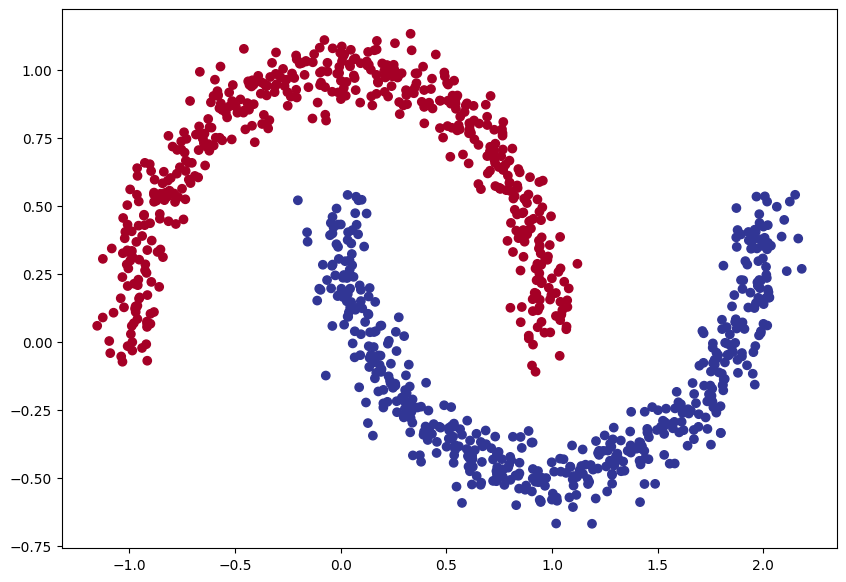

In [21]:
import matplotlib.pyplot as plt
#visualize the data on a scatter plot
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)


In [22]:
#Turn the data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
#Split the data into train and test sets (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test), X.dtype, y.dtype

(800, 200, 800, 200, torch.float32, torch.float32)

##Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [23]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
  def __init__(self, in_feats, out_feats, hidden_feats):
    super().__init__()
    self.stacked_layers = nn.Sequential(
        nn.Linear(in_features=in_feats, out_features=hidden_feats),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feats, out_features=hidden_feats),
        nn.ReLU(),
        nn.Linear(in_features=hidden_feats, out_features=out_feats)
    )
  def forward(self, x):
    return self.stacked_layers(x)
model_0 = MoonModelV0(in_feats=2, out_feats=1, hidden_feats=10).to(device)
model_0

MoonModelV0(
  (stacked_layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [24]:
loss_fn = nn.BCELoss() # sigmoid layer built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of model to optimize
                            lr=0.1) # learning rate

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [26]:
torch.sigmoid(test_logits).shape

torch.Size([200, 4])

In [27]:
epochs = 1000
for epoch in range(epochs):
  #Training mode on
  model_0.train()
  # forward pass
  pred_logits = model_0(X_train).squeeze()
  pred_probs = torch.sigmoid(pred_logits)
  #Calculate the loss
  loss = loss_fn(pred_probs, y_train)
  #Optimizer zero grad
  optimizer.zero_grad()
  #loss back propagation
  loss.backward()
  #optimizer step
  optimizer.step()
  #Test loop:
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred_probs = torch.sigmoid(test_logits)
    #Calculate the loss
    test_loss = loss_fn(test_pred_probs, y_test)
    if epoch % 100 == 0:
      print(f" epch: {epoch} | train_loss: {loss} | test_loss: {test_loss}")


 epch: 0 | train_loss: 0.6953220963478088 | test_loss: 0.6944555044174194
 epch: 100 | train_loss: 0.38864612579345703 | test_loss: 0.40304461121559143
 epch: 200 | train_loss: 0.24289436638355255 | test_loss: 0.24101947247982025
 epch: 300 | train_loss: 0.20105227828025818 | test_loss: 0.1915328949689865
 epch: 400 | train_loss: 0.16583594679832458 | test_loss: 0.15421293675899506
 epch: 500 | train_loss: 0.12357869744300842 | test_loss: 0.11175338923931122
 epch: 600 | train_loss: 0.08451852202415466 | test_loss: 0.0740097165107727
 epch: 700 | train_loss: 0.056622058153152466 | test_loss: 0.048111442476511
 epch: 800 | train_loss: 0.04003177210688591 | test_loss: 0.032839685678482056
 epch: 900 | train_loss: 0.029989013448357582 | test_loss: 0.023943668231368065


In [28]:
pred_probs[:10], y_train[:10]

(tensor([9.9775e-01, 3.1330e-03, 2.0701e-02, 3.4842e-02, 9.9640e-01, 4.6031e-02,
         9.9353e-01, 9.9241e-01, 9.1627e-04, 1.8520e-02],
        grad_fn=<SliceBackward0>),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

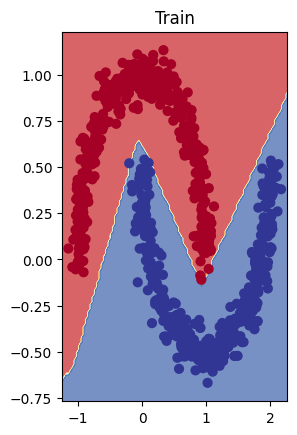

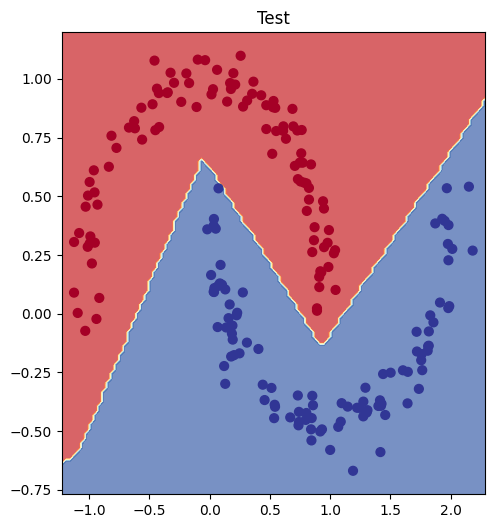

<Figure size 1200x600 with 0 Axes>

In [29]:
import numpy as np
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [30]:
model_0.state_dict()

OrderedDict([('stacked_layers.0.weight',
              tensor([[ 1.9937,  0.5040],
                      [-0.1476,  0.8226],
                      [-0.1549,  0.1427],
                      [-0.5087,  1.0268],
                      [ 1.1381, -0.3946],
                      [ 1.3407, -0.1618],
                      [ 0.8310,  0.0110],
                      [ 0.9214, -0.0265],
                      [ 1.1180, -0.1447],
                      [-0.3301,  0.1802]])),
             ('stacked_layers.0.bias',
              tensor([-0.1938,  0.4393, -0.2872,  0.8277, -1.0847, -1.2626, -0.0504, -0.8983,
                       1.1242, -0.6984])),
             ('stacked_layers.2.weight',
              tensor([[-0.7046, -0.4668,  0.2441, -0.2306,  0.7151,  1.0620, -0.2242,  0.8711,
                        0.9248, -0.0997],
                      [ 1.4045,  0.5101,  0.1331,  1.2598, -0.7186, -0.9974,  0.6295, -0.6248,
                       -0.5502, -0.1927],
                      [-1.0904, -0.2512, -0.2

In [31]:
model_0(X_train).squeeze().shape

torch.Size([800])

In [32]:
torch.sigmoid(model_0(X_train).squeeze())[:10]

tensor([9.9776e-01, 3.1202e-03, 2.0686e-02, 3.4826e-02, 9.9642e-01, 4.5994e-02,
        9.9355e-01, 9.9245e-01, 9.1186e-04, 1.8465e-02],
       grad_fn=<SliceBackward0>)

In [33]:
torch.round(torch.sigmoid(model_0(X_train).squeeze())[:10])

tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.], grad_fn=<RoundBackward0>)

##6. Replicate the Tanh activation fn w/ pure pytorch.

In [34]:
straight_line = torch.arange(-100,100,1)
straight_line

tensor([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,  -89,
         -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,  -78,  -77,
         -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,  -67,  -66,  -65,
         -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,  -56,  -55,  -54,  -53,
         -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,  -42,  -41,
         -40,  -39,  -38,  -37,  -36,  -35,  -34,  -33,  -32,  -31,  -30,  -29,
         -28,  -27,  -26,  -25,  -24,  -23,  -22,  -21,  -20,  -19,  -18,  -17,
         -16,  -15,  -14,  -13,  -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,
          -4,   -3,   -2,   -1,    0,    1,    2,    3,    4,    5,    6,    7,
           8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
          20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
          32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   

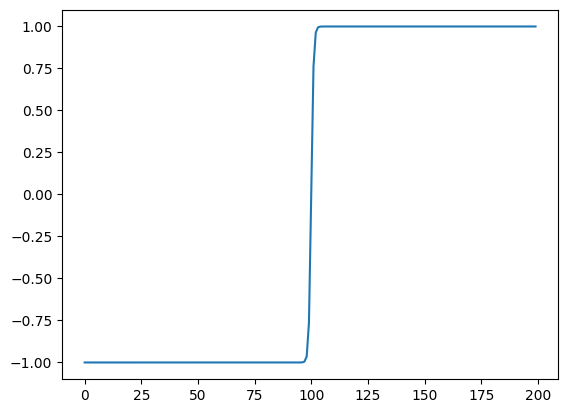

In [35]:
tensor_a = torch.tanh(straight_line)
plt.plot(tensor_a)

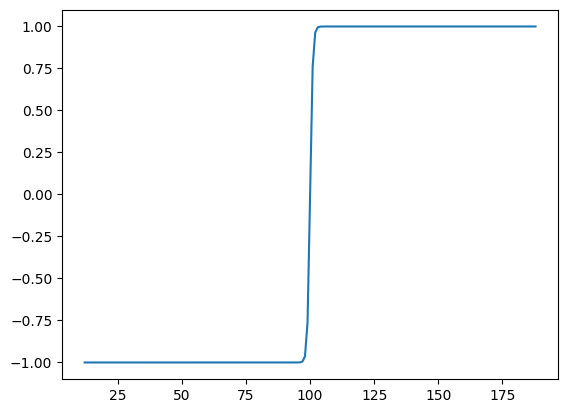

In [36]:
def tanh(z):
  return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))
plt.plot(tanh(straight_line))

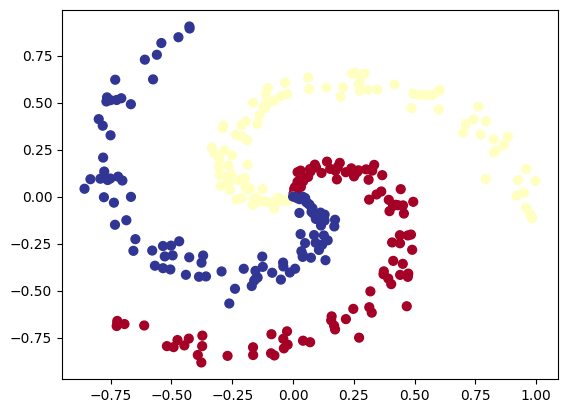

In [43]:

# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [44]:

# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=RANDOM_SEED, test_size=0.2)

In [46]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn


MulticlassAccuracy()

In [49]:
from torch import nn

class RadialModelV0(nn.Module):
  def __init__(self,in_features, out_features, hidden_features):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features, out_features=out_features)
    )

  def forward(self, x):
    return self.layers(x)

model_1 = RadialModelV0(in_features=2, out_features=4, hidden_features=12)

In [51]:
#Logits

with torch.inference_mode():
  logits = model_1(X_train)
  print("Logits: ")
  print(f"{logits[:10]}")
  print("Pred Probs: ")
  pred_probs = torch.softmax(model_1(X_train)[:10], dim=1)
  print(pred_probs)
  print("Pred Labels: ")
  pred_labels = torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1)
  print(pred_labels)

Logits: 
tensor([[-0.0105,  0.1267,  0.2239,  0.1394],
        [-0.0011,  0.1201,  0.2316,  0.1576],
        [-0.0067,  0.1273,  0.2306,  0.1288],
        [ 0.0397,  0.1022,  0.2703,  0.1766],
        [ 0.0252,  0.1162,  0.2606,  0.1473],
        [ 0.0010,  0.1214,  0.2367,  0.1418],
        [-0.0017,  0.1238,  0.2349,  0.1357],
        [-0.0257,  0.1348,  0.2094,  0.0983],
        [ 0.0039,  0.1164,  0.2365,  0.1618],
        [ 0.0407,  0.1020,  0.2713,  0.1767]])
Pred Probs: 
tensor([[0.2187, 0.2508, 0.2764, 0.2540],
        [0.2192, 0.2474, 0.2766, 0.2569],
        [0.2195, 0.2509, 0.2783, 0.2513],
        [0.2237, 0.2381, 0.2817, 0.2565],
        [0.2227, 0.2439, 0.2818, 0.2516],
        [0.2200, 0.2482, 0.2785, 0.2533],
        [0.2199, 0.2493, 0.2786, 0.2523],
        [0.2188, 0.2569, 0.2767, 0.2476],
        [0.2197, 0.2459, 0.2772, 0.2573],
        [0.2238, 0.2380, 0.2818, 0.2564]])
Pred Labels: 
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)


In [68]:
epochs = 1000
for epoch in range(epochs):
  #training mode
  model_1.train()
  #forward pass
  train_logits = model_1(X_train)
  #Calculate the loss
  train_loss = loss_fn(train_logits, y_train)
  #Optimizer zero grad
  optimizer.zero_grad()
  #Loss backward
  train_loss.backward()
  #Optimizer step
  optimizer.step()
  #Eval mode
  model_1.eval()
  with torch.inference_mode():
    #do the forward pass
    test_logits = model_1(X_test)
    #Calculate the loss
    loss = loss_fn(test_logits, y_test)
    #Print out what's happening
    if epoch % 100 == 0:
      print(f"epoch: {epoch} | train loss: {train_loss} | test loss: {test_loss}")

epoch: 0 | train loss: 0.3213459849357605 | test loss: 0.01849200390279293
epoch: 100 | train loss: 0.3152516484260559 | test loss: 0.01849200390279293
epoch: 200 | train loss: 0.3092365562915802 | test loss: 0.01849200390279293
epoch: 300 | train loss: 0.3032788038253784 | test loss: 0.01849200390279293
epoch: 400 | train loss: 0.2974247336387634 | test loss: 0.01849200390279293
epoch: 500 | train loss: 0.29173949360847473 | test loss: 0.01849200390279293
epoch: 600 | train loss: 0.28612220287323 | test loss: 0.01849200390279293
epoch: 700 | train loss: 0.28067705035209656 | test loss: 0.01849200390279293
epoch: 800 | train loss: 0.2753019332885742 | test loss: 0.01849200390279293
epoch: 900 | train loss: 0.27008411288261414 | test loss: 0.01849200390279293


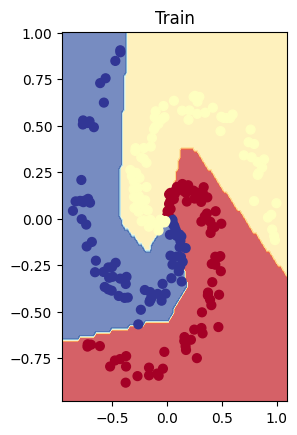

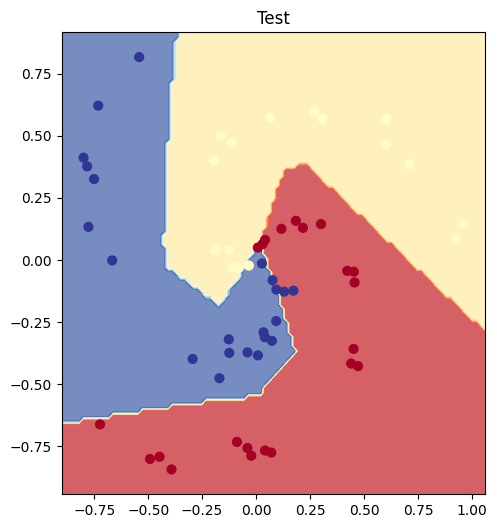

<Figure size 1200x600 with 0 Axes>

In [70]:
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)